# 10. Final Figures
21 March 2020

Updating the figures from the submitted manuscript to reflect the use of ANOVA with post-hoc Tukey's test instead of the two-sided student t-test. 

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import numpy as np
from pprint import pprint
from os.path import join as oj, isfile
from itertools import combinations
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import namedtuple

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import psturng

from scipy.stats import spearmanr, kruskal
from scipy.stats import zscore
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams['hatch.linewidth'] = 3.0  # previous svg hatch linewidth

# static variables
EMORY_DATA = pd.read_csv('../CSVs/Emory_data.csv')
TANG_DATA = pd.read_csv('../CSVs/Tang_data.csv')

DATA_DIR = '/mnt/Data/figures/'

# subset tang_data to only the hold-out dataset
TANG_DATA = TANG_DATA[TANG_DATA['Group'] == 'hold out'].reset_index(drop=True)

# convert Regan column to int
mapping = {'no': 0, 'low': 0, 'intermediate': 1, 'high': 2}
EMORY_DATA = EMORY_DATA.replace({'Reagan': mapping})


flierprops = dict(marker='+', markerfacecolor='red', markersize=12, markeredgecolor='red', linestyle='none')
cdict = {'red':   ((0.0, 0.0, 1.0),
                   (1.301/4, 0.7, 0.7),
                   (1.0, 0/255, 0.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.301/4, 0.7, 0.7),
                   (1.0, 100/255, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.301/4,0.7,0.7),
                   (1.0, 1.0, 0.0))
        }
colorbar = LinearSegmentedColormap('pvalue', cdict)


def p_show(p):
    for i in range(2,15):
        if p > 1/10**i:
            return round(p, i+1)


def get_significance_label(p):
    if p > 0.05:
        return 'n.s.'
    if p > 0.01:
        return '*'
    if p > 0.001: 
        return '**'
    if p > 0.0001:
        return '***'
    return '****'


def plot_cnn_scores(file, category_col, score_col, x_param, ylabel=None, xlabel=None, save_name=None,
                   figsize=(12,10), fontsize=30, labelsize=30, ylim=None, facecolor='white', rotation=45,
                   title='', sig=True, corr_flag=True, nonparametric=False):
    """A function for plotting the CNN scores in whisker and box plot style grouped together by categorical
    feature.
    
    :param data : dataframe
        dataframe containing the data
    :param 
    """
    results = {}
    
    # "1) Spearman's Rank-order Coefficient"
    scores = file[score_col].tolist()
    categories = file[category_col].tolist()
    
    if corr_flag:
        rho, p = spearmanr(scores, categories)
        results['spearman_pvalue'] = p
        results['spearman_coef'] = rho
    
    # if only two categories, then do a t-test
    ttest_flag = True
    if len(x_param) < 2:
        raise Exception('There must be at least 2 categories')
    elif len(x_param) > 2:
        ttest_flag = False
        
        if nonparametric:
            s, p = kruskal(*[group[score_col].values for name, group in EMORY_DATA.groupby(category_col)])
            results['kruskal_statistic'] = s
            results['kruskal_pvalue'] = p
        else:
            # "2) ANOVA"
            anova_results = ols(f'{score_col} ~ C({category_col})', data=file).fit()
            results['anova_pvalue'] = anova_results.f_pvalue
            results['anova_fvalue'] = anova_results.fvalue
    
        # "3) Post-hoc tests for all group comparisons - Tukey's test"
        mc = MultiComparison(file[score_col], file[category_col])
        mc.tukeyhsd()
        mc_results = mc.tukeyhsd().summary().data
        mc_results = pd.DataFrame(data=mc_results[1:], columns=mc_results[0])
        results['tukeys_results'] = mc_results

    # "4) Plot the boxplots with adjacent group significant bars"
    flierprops = dict(marker='+', markerfacecolor='red', markersize=12, markeredgecolor='red', linestyle='none')
    data = []
    scores = list(x_param.keys())
    values = [x_param[s] for s in scores]
    for score in scores:
        count = np.asarray(file[file[category_col]==score][score_col])
        print("{} count: {}".format(x_param[score], len(count)))
        count.shape = (-1,1)
        data.append(count[~np.isnan(count)])
        
    # box plot and dot plot
    fig = plt.figure(figsize=figsize, dpi=100)
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data, flierprops=flierprops, showmeans=False, patch_artist=True)
    plt.setp(bp['boxes'], lw=3)
    plt.setp(bp['whiskers'], lw=3)
    plt.setp(bp['caps'], lw=3)
    
    for patch in bp['boxes']:
        patch.set(facecolor=facecolor)
        
    N = len(list(x_param.keys()))
    for i in range(N):
        plt.setp(bp['medians'][i], color='#D81B60', lw=3)
        
    # t test - calculate p-values
    max_value = max([d.max() for d in data])
       
    if sig:
        for x in range(1, N):
            if ttest_flag:
                _, p = stats.ttest_ind(data[x-1], data[x], nan_policy='omit')
            else:
                # get the Tukey's p-value for this adjacent pair
                p = mc_results[(mc_results['group1']==x-1) & (mc_results['group2'] == x)]['p-adj'].values[0]
            
            # plot significance label
            x1, x2 = x+0.03, x+0.97   
            y, h, col = max_value*1.1, max_value*0.03, 'k'
            text = get_significance_label(p)
            
            if text != 'n.s.':
                ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color=col, fontsize=25)    
    
    # calculate all the p-values
    # calculate the other p-values (non-adjacent groups
    for c in combinations(list(range(N)), 2):
        if ttest_flag:
            _, p = stats.ttest_ind(data[c[0]], data[c[1]], nan_policy='omit')
        else:
            p = mc_results[(mc_results['group1']==c[0]) & (mc_results['group2'] == c[1])]['p-adj'].values[0]
            
        print('{}, {}: p-value of {}'.format(values[c[0]], values[c[1]], p))

    if ylim != 'auto':
        ax.set_ylim([-max([d.max() for d in data])/10, max([d.max() for d in data])*1.3])
    _ = ax.set_xticklabels(list(x_param.values()))
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=labelsize, size=0, width=2, rotation=rotation)
    ax.yaxis.set_tick_params(labelsize=labelsize, size=5, width=2)
    ax.set_title(title, fontsize=fontsize+2)
    
       
    if save_name is not None:
        fig.savefig(save_name, bbox_inches='tight', dpi=300)
        plt.pause(0.001)
    plt.show()
    
    return results


def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color='#D81B60')
    
    
# functions
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')


def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0


def fov_correlation(data_path, fov_dir, n=1, plot=False, reagan=False):
    """Plot correlation of the average n denset FOV in each image vs the whole tissue image.
    
    :param data_path : str
        path to data file for case info, CERAD categories, and whole tissue scores
    :param fov_dir : str
        the dir containing the fov csv files for each case
    :param n : int (default of 1)
        the n highest FOV scores to use
    """
    labels=('cored', 'diffuse', 'caa')
    fov_labels = ('cored_densest_fov', 'diffuse_densest_fov', 'caa_densest_fov')
    tissue_labels = ('tissue_cored_score', 'tissue_diffuse_score', 'tissue_caa_score')
    
    if reagan:
        category_labels = ('Reagan', 'Reagan', 'Reagan')
    else:
        category_labels = ('Cored_MTG', 'Diffuse_MTG', 'CAA_MTG')
    df = pd.read_csv(data_path)
    mapping = {'no': 0, 'low': 0, 'intermediate': 1, 'high': 2}
    df = df.replace({'Reagan': mapping})
    
    # add a column for densest FOV count for each case's plaques types (cored, diffuse, caa)
    densest_scores = [[], [], []]

    for idx, row in df.iterrows():
        # load the fov scores for this case
        fov_df = pd.read_csv(oj(fov_scores_dir, row['WSI_ID'] + '.csv'))

        for i, label in enumerate(labels):
            # subset each type of plaque
            df_subset = fov_df[fov_df['label']==label].reset_index(drop=True)
            
            # sort by counts
            df_subset = df_subset.sort_values(by=['count'], ascending=False).reset_index(drop=True)
            
            # df subset is 0 then just return 0
            if len(df_subset) == 0:
                densest_scores[i].append(0)
                continue
                            
            # take the n highest non-overlapping counts
            x, y = df_subset.loc[0, 'x'], df_subset.loc[0, 'y']
            w, h = df_subset.loc[0, 'width'], df_subset.loc[0, 'height']
            scores = [df_subset.loc[0, 'count'] * 100 / (w * h)]
            coords = [Rectangle(x, y, x + w, y + h)]
            
            for j in range(1, len(df_subset)):
                # if we already have the top n counts, then stop
                if len(scores) == n:
                    break
                    
                # else check the this region to make sure it does not overlap with previous regions
                x, y = df_subset.loc[j, 'x'], df_subset.loc[j, 'y']
                w, h = df_subset.loc[j, 'width'], df_subset.loc[j, 'height']
                r = Rectangle(x, y, x + w, y + h)
                
                # for all already region check
                flag = False
                for coord in coords:
                    if area(coord, r) != 0:
                        flag = True
                        break
                
                # if flag did not change to true then this region does not overlap, add it
                if not flag:
                    coords.append(r)
                    scores.append(df_subset.loc[j, 'count'] * 100 / (w * h))
                    
            # convert scores to average and append to denset list - note that there may be less than n 
            # entries if not enough non-overlapping regions
            densest_scores[i].append(sum(scores) / len(scores))
            
    # add the densest fov column (scores)
    for i in range(3):
        df[fov_labels[i]] = densest_scores[i]
        
    # sort the tissue scores and densest FOV scores and plot against each other
    rhos = []
    for i in range(3):
        tissue_scores = df[tissue_labels[i]].tolist()
        fov_scores = df[fov_labels[i]].tolist()
        
        # return spearman correlation with the CERAD like scores
        rho, p = spearmanr(fov_scores, df[category_labels[i]].tolist())
        rhos.append(rho)
        
        # calaculate spearman correlation between tissue and fov scores
        rho, p = spearmanr(tissue_scores, fov_scores)
#       
        
        # sort the lists together before plotting
        tissue_scores, fov_scores = (list(t) for t in zip(*sorted(zip(tissue_scores, fov_scores))))
        
        if plot:
            plt.figure(figsize=(7, 5))
            plt.plot(tissue_scores, fov_scores, '.-')
            plt.xlabel('Tissue CNN Scores', fontsize=16)
            plt.ylabel('{} FOV CNN-Scores'.format(n), fontsize=16)
            plt.title('r: {:0.3f}'.format(float(rho)))
            plt.show()

            x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
            plotting.plot_cnn_scores(df, category_labels[i], fov_labels[i], x_param, 
                                     ylabel='{} Highest FOV CNN-Scores'.format(n),
                                     xlabel='CERAD-like scores')
            
        
    return rhos

## Figure 2 - WT CNN scores vs CERAD-like (Emory dataset)

None count: 10
Sparse count: 13
Moderate count: 14
Frequent count: 3
None, Sparse: p-value of 0.0185
None, Moderate: p-value of 0.001
None, Frequent: p-value of 0.001
Sparse, Moderate: p-value of 0.3027
Sparse, Frequent: p-value of 0.0019
Moderate, Frequent: p-value of 0.0302


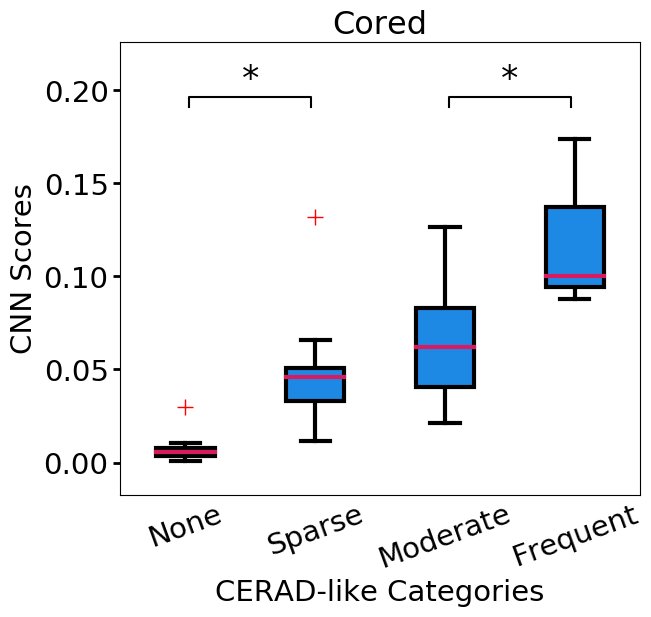

{'anova_fvalue': 14.139330078778855,
 'anova_pvalue': 3.012361734497602e-06,
 'spearman_coef': 0.7686633266354999,
 'spearman_pvalue': 6.952251955820954e-09,
 'tukeys_results':    group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1    0.0384  0.0185  0.0051  0.0718    True
1       0       2    0.0585  0.0010  0.0257  0.0913    True
2       0       3    0.1130  0.0010  0.0608  0.1651    True
3       1       2    0.0201  0.3027 -0.0104  0.0506   False
4       1       3    0.0745  0.0019  0.0238  0.1253    True
5       2       3    0.0544  0.0302  0.0040  0.1048    True}

None count: 6
Sparse count: 3
Moderate count: 3
Frequent count: 28
None, Sparse: p-value of 0.9
None, Moderate: p-value of 0.0461
None, Frequent: p-value of 0.001
Sparse, Moderate: p-value of 0.1925
Sparse, Frequent: p-value of 0.001
Moderate, Frequent: p-value of 0.4422


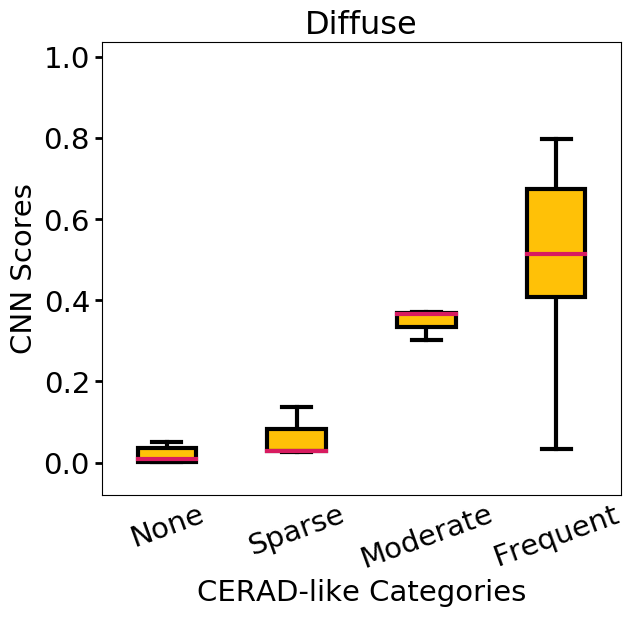

{'anova_fvalue': 17.403640711101502,
 'anova_pvalue': 3.774151211359576e-07,
 'spearman_coef': 0.7350767526737723,
 'spearman_pvalue': 6.61276550336721e-08,
 'tukeys_results':    group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1    0.0448  0.9000 -0.2789  0.3686   False
1       0       2    0.3280  0.0461  0.0043  0.6517    True
2       0       3    0.4842  0.0010  0.2782  0.6902    True
3       1       2    0.2832  0.1925 -0.0906  0.6570   False
4       1       3    0.4394  0.0010  0.1612  0.7175    True
5       2       3    0.1562  0.4422 -0.1219  0.4343   False}

None count: 19
Sparse count: 5
Moderate count: 6
Frequent count: 10
None, Sparse: p-value of 0.9
None, Moderate: p-value of 0.3694
None, Frequent: p-value of 0.006
Sparse, Moderate: p-value of 0.5447
Sparse, Frequent: p-value of 0.0633
Moderate, Frequent: p-value of 0.6256


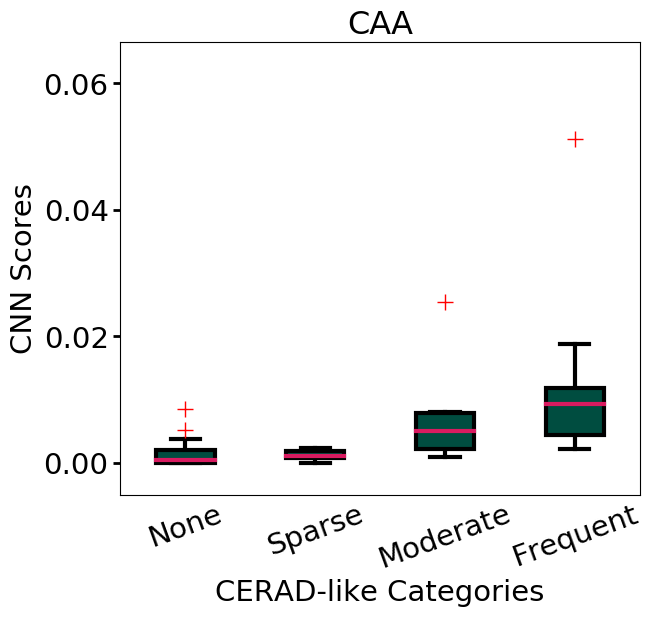

{'anova_fvalue': 4.769339831689373,
 'anova_pvalue': 0.006703580006039915,
 'spearman_coef': 0.6837438616780348,
 'spearman_pvalue': 1.1551980283054536e-06,
 'tukeys_results':    group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1   -0.0003  0.9000 -0.0113  0.0107   False
1       0       2    0.0063  0.3694 -0.0040  0.0165   False
2       0       3    0.0112  0.0060  0.0027  0.0198    True
3       1       2    0.0066  0.5447 -0.0067  0.0198   False
4       1       3    0.0115  0.0633 -0.0005  0.0235   False
5       2       3    0.0050  0.6256 -0.0063  0.0163   False}


In [8]:
# Tissue CNN scores vs CERAD-like categories (Emory dataset)

x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
r = plot_cnn_scores(EMORY_DATA, 'Cored_MTG', 'tissue_cored_score', x_param, figsize=(6.7, 6), facecolor='#1E88E5',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, save_name=oj(DATA_DIR, 'fig2_part1.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'Diffuse_MTG', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), facecolor='#FFC107',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, save_name=oj(DATA_DIR, 'fig2_part2.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'CAA_MTG', 'tissue_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21, 
                        title='CAA', rotation=20, save_name=oj(DATA_DIR, 'fig2_part3.png'))
pprint(r)

None count: 19
Sparse count: 5
Moderate count: 6
Frequent count: 10
None, Sparse: p-value of 0.9
None, Moderate: p-value of 0.3694
None, Frequent: p-value of 0.006
Sparse, Moderate: p-value of 0.5447
Sparse, Frequent: p-value of 0.0633
Moderate, Frequent: p-value of 0.6256


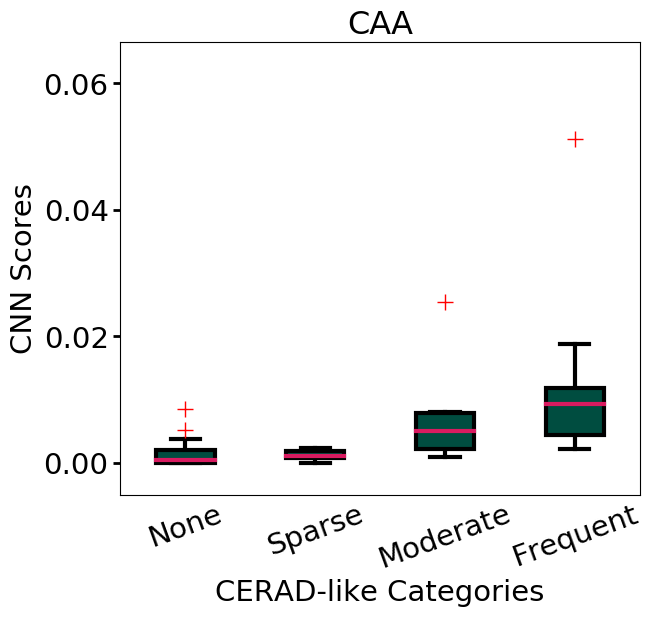

{'kruskal_pvalue': 0.00016430707843768586,
 'kruskal_statistic': 20.06819670829281,
 'spearman_coef': 0.6837438616780348,
 'spearman_pvalue': 1.1551980283054536e-06,
 'tukeys_results':    group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1   -0.0003  0.9000 -0.0113  0.0107   False
1       0       2    0.0063  0.3694 -0.0040  0.0165   False
2       0       3    0.0112  0.0060  0.0027  0.0198    True
3       1       2    0.0066  0.5447 -0.0067  0.0198   False
4       1       3    0.0115  0.0633 -0.0005  0.0235   False
5       2       3    0.0050  0.6256 -0.0063  0.0163   False}


In [9]:
r = plot_cnn_scores(EMORY_DATA, 'CAA_MTG', 'tissue_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21, 
                        title='CAA', rotation=20, nonparametric=True)
pprint(r)

## Additional File 2: Figure S3 - WT CNN Scores vs CERAD-like (combined dataset)

In [ ]:
# Tissue CNN scores vs CERAD-like categories (Combined Tang & Emory datasets)

df = pd.concat([EMORY_DATA, TANG_DATA], sort=False)

x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
r = plot_cnn_scores(df, 'Cored_MTG', 'tissue_cored_score', x_param, figsize=(6.7, 6), facecolor='#1E88E5',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, save_name=oj(DATA_DIR, 'figS3_part1.png'))
pprint(r)
print()
r = plot_cnn_scores(df, 'Diffuse_MTG', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), facecolor='#FFC107',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, save_name=oj(DATA_DIR, 'figS3_part2.png'))
pprint(r)
print()
plot_cnn_scores(df, 'CAA_MTG', 'tissue_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, save_name=oj(DATA_DIR, 'figS3_part3.png'))

## Figure 3 - WT CNN score vs Pathological Dx (cored and diffuse)
## Also - Figure S5 - """ """ (CAA)

In [ ]:
# "1) comparing control vs pure AD"
# create new column - map 0 to control and 1 to AD
dx_id = []
for i, r in EMORY_DATA.iterrows():
    dxs = [r['Primary Dx'], r['Secondary Dx (1)'], r['Secondary Dx (2)']]
           
    # remove nones
    dxs = [dx for dx in dxs if dx not in ['none', 'amyg LB']]
    
    # remap poss AD and prob AD to AD
    for j, dx in enumerate(dxs):
        if dx in ['poss AD', 'prob AD']:
            dxs[j] = 'AD'
    
    if len(dxs) == 1 and dxs[0] == 'control':
        dx_id.append(0)
    elif len(dxs) == 1 and dxs[0] == 'AD':
        dx_id.append(1)
    else:
        dx_id.append(-1)
        
df1 = EMORY_DATA.assign(Pathology_ID = dx_id)
df1 = df1[df1['Pathology_ID'] != -1].reset_index(drop=True)

x_param = {0: 'control', 1: 'Pure AD'}
r = plot_cnn_scores(df1, 'Pathology_ID', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'fig3_part1'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df1, 'Pathology_ID', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'fig3_part4'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df1, 'Pathology_ID', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS5_part1'), corr_flag=False)
pprint(r)

In [ ]:
# "2) comparing control vs all AD"
# create new column - map 0 to control and 1 to AD
dx_id = []
for i, r in EMORY_DATA.iterrows():
    dxs = [r['Primary Dx'], r['Secondary Dx (1)'], r['Secondary Dx (2)']]
           
    # remove nones
    dxs = [dx for dx in dxs if dx not in ['none', 'amyg LB']]
    
    # remap poss AD and prob AD to AD
    for j, dx in enumerate(dxs):
        if dx in ['poss AD', 'prob AD']:
            dxs[j] = 'AD'
    if len(dxs) == 1 and dxs[0] == 'control':
        dx_id.append(0)
    elif 'AD' in dxs and 'control' not in dxs:
        dx_id.append(1)
    else:
        dx_id.append(-1)
        
df2 = EMORY_DATA.assign(Pathology_ID = dx_id)
df2 = df2[df2['Pathology_ID'] != -1].reset_index(drop=True)

x_param = {0: 'control', 1: 'All AD'}
r = plot_cnn_scores(df2, 'Pathology_ID', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'fig3_part2'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df2, 'Pathology_ID', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'fig3_part5'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df2, 'Pathology_ID', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS5_part2'), corr_flag=False)
pprint(r)

In [ ]:
# "3) comparing pure AD vs AD+TDP vs AD+LBD"
# create new column - map 0 to AD, 1 to AD+TDP, and 2 to AD+LBD
dx_id = []
for i, r in EMORY_DATA.iterrows():
    dxs = [r['Primary Dx'], r['Secondary Dx (1)'], r['Secondary Dx (2)']]
           
    # remove nones
    dxs = [dx for dx in dxs if dx not in ['none', 'amyg LB']]
    
    # remap poss AD and prob AD to AD
    for j, dx in enumerate(dxs):
        if dx in ['poss AD', 'prob AD']:
            dxs[j] = 'AD'
    
    if len(dxs) == 1 and dxs[0] == 'AD':
        dx_id.append(0)
    elif len(dxs) == 2 and 'AD' in dxs:
        if 'TDP' in dxs:
            dx_id.append(1)
        elif 'DLB' in dxs:
            dx_id.append(2)
        else:
            dx_id.append(-1)
    
    else:
        dx_id.append(-1)
        
df3 = EMORY_DATA.assign(Pathology_ID = dx_id)
df3 = df3[df3['Pathology_ID'] != -1].reset_index(drop=True)

x_param = {0: 'Pure AD', 1: 'AD+TDP', 2: 'AD+LBD'}
r = plot_cnn_scores(df3, 'Pathology_ID', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'fig3_part3'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df3, 'Pathology_ID', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'fig3_part6'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df3, 'Pathology_ID', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS5_part3'), corr_flag=False)
pprint(r)

## Figure S4 - WT CNN score vs Pathological Dx (including cognitive normal AD cases)

In [ ]:
# "1) comparing control vs pure AD"
# create new column - map 0 to control and 1 to AD
dx_id = []
for i, r in EMORY_DATA.iterrows():
    dxs = [r['Primary Dx'], r['Secondary Dx (1)'], r['Secondary Dx (2)']]
           
    # remove nones
    dxs = [dx for dx in dxs if dx not in ['none', 'amyg LB']]
    
    # remap poss AD and prob AD to AD
    for j, dx in enumerate(dxs):
        if dx in ['poss AD', 'prob AD']:
            dxs[j] = 'AD'
    
    if len(dxs) == 2 and dxs[0] == 'control' and dxs[1] == 'AD':
        dx_id.append(1)
    elif len(dxs) == 1 and dxs[0] == 'control':
        dx_id.append(0)
    elif len(dxs) == 1 and dxs[0] == 'AD':
        dx_id.append(1)
    else:
        dx_id.append(-1)
        
df = EMORY_DATA.assign(Pathology_ID = dx_id)
df = df[df['Pathology_ID'] != -1].reset_index(drop=True)

x_param = {0: 'control', 1: 'Pure AD'}
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part1'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part2'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part3'), corr_flag=False)
pprint(r)

In [ ]:
# "2) comparing control vs all AD"
# create new column - map 0 to control and 1 to AD
dx_id = []
for i, r in EMORY_DATA.iterrows():
    dxs = [r['Primary Dx'], r['Secondary Dx (1)'], r['Secondary Dx (2)']]
           
    # remove nones
    dxs = [dx for dx in dxs if dx not in ['none', 'amyg LB']]
    
    # remap poss AD and prob AD to AD
    for j, dx in enumerate(dxs):
        if dx in ['poss AD', 'prob AD']:
            dxs[j] = 'AD'
            
    if len(dxs) == 2 and dxs[0] == 'control' and dxs[1] == 'AD':
        dx_id.append(1)
    elif len(dxs) == 1 and dxs[0] == 'control':
        dx_id.append(0)
    elif 'AD' in dxs and 'control' not in dxs:
        dx_id.append(1)
    else:
        dx_id.append(-1)
        
df = EMORY_DATA.assign(Pathology_ID = dx_id)
df = df[df['Pathology_ID'] != -1].reset_index(drop=True)

x_param = {0: 'control', 1: 'All AD'}
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part4'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part5'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part6'), corr_flag=False)
pprint(r)

In [ ]:
# "3) comparing pure AD vs AD+TDP vs AD+LBD"
# create new column - map 0 to AD, 1 to AD+TDP, and 2 to AD+LBD
dx_id = []
for i, r in EMORY_DATA.iterrows():
    dxs = [r['Primary Dx'], r['Secondary Dx (1)'], r['Secondary Dx (2)']]
           
    # remove nones
    dxs = [dx for dx in dxs if dx not in ['none', 'amyg LB']]
    
    # remap poss AD and prob AD to AD
    for j, dx in enumerate(dxs):
        if dx in ['poss AD', 'prob AD']:
            dxs[j] = 'AD'
    
    if len(dxs) == 2 and dxs[0] == 'control' and dxs[1] == 'AD':
        dx_id.append(0)
    elif len(dxs) == 1 and dxs[0] == 'AD':
        dx_id.append(0)
    elif len(dxs) == 2 and 'AD' in dxs:
        if 'TDP' in dxs:
            dx_id.append(1)
        elif 'DLB' in dxs:
            dx_id.append(2)
        else:
            dx_id.append(-1)
    
    else:
        dx_id.append(-1)
        
df = EMORY_DATA.assign(Pathology_ID = dx_id)
df = df[df['Pathology_ID'] != -1].reset_index(drop=True)

x_param = {0: 'Pure AD', 1: 'AD+TDP', 2: 'AD+LBD'}
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part7'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part8'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df, 'Pathology_ID', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS4_part9'), corr_flag=False)
pprint(r)

## Fig 4 - WT CNN Scores vs Reagan Comparisons

In [ ]:
x_param = {0: 'no/low', 1: 'intermediate', 2: 'high'}

r = plot_cnn_scores(EMORY_DATA, 'Reagan', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                    labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                    title='Cored', rotation=0, facecolor='white', save_name=oj(DATA_DIR, 'fig4_part1.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'Reagan', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                    labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                    title='Diffuse', rotation=0, facecolor='white', save_name=oj(DATA_DIR, 'fig4_part2.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'Reagan', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                    labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                    title='CAA', rotation=0, facecolor='white', save_name=oj(DATA_DIR, 'fig4_part3.png'))
pprint(r)

## Fig S6 - GM CNN score vs CERAD-like Categories (Emory dataset)

In [ ]:
x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
r = plot_cnn_scores(EMORY_DATA, 'Cored_MTG', 'gm_cored_score', x_param, figsize=(6.7, 6), facecolor='#1E88E5',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, save_name=oj(DATA_DIR, 'figS6_part1.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'Diffuse_MTG', 'gm_diffuse_score', x_param, figsize=(6.7, 6), facecolor='#FFC107',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, save_name=oj(DATA_DIR, 'figS6_part2.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'CAA_MTG', 'gm_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, save_name=oj(DATA_DIR, 'figS6_part3.png'))
pprint(r)

## S7 - GM CNN Scores vs Pathological Diagnosis

In [ ]:
x_param = {0: 'control', 1: 'Pure AD'}
r = plot_cnn_scores(df1, 'Pathology_ID', 'gm_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part1'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df1, 'Pathology_ID', 'gm_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part4'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df1, 'Pathology_ID', 'gm_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part7'), corr_flag=False)
pprint(r)

In [ ]:
x_param = {0: 'control', 1: 'All AD'}
r = plot_cnn_scores(df2, 'Pathology_ID', 'gm_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part2'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df2, 'Pathology_ID', 'gm_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part5'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df2, 'Pathology_ID', 'gm_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part8'), corr_flag=False)
pprint(r)

In [ ]:
x_param = {0: 'Pure AD', 1: 'AD+TDP', 2: 'AD+LBD'}
r = plot_cnn_scores(df3, 'Pathology_ID', 'gm_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part3'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df3, 'Pathology_ID', 'gm_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part6'), corr_flag=False)
pprint(r)
print()
r = plot_cnn_scores(df3, 'Pathology_ID', 'gm_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', 
                        save_name=oj(DATA_DIR, 'figS7_part9'), corr_flag=False)
pprint(r)

## Fig S8 - GM CNN Scores vs Reagan Score

In [ ]:
x_param = {0: 'no/low', 1: 'intermediate', 2: 'high'}

r = plot_cnn_scores(EMORY_DATA, 'Reagan', 'gm_cored_score', x_param, figsize=(6.7, 6), 
                    labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                    title='Cored', rotation=0, facecolor='white', save_name=oj(DATA_DIR, 'figS8_part1.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'Reagan', 'gm_diffuse_score', x_param, figsize=(6.7, 6), 
                    labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                    title='Diffuse', rotation=0, facecolor='white', save_name=oj(DATA_DIR, 'figS8_part2.png'))
pprint(r)
print()
r = plot_cnn_scores(EMORY_DATA, 'Reagan', 'gm_caa_score', x_param, figsize=(6.7, 6), 
                    labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                    title='CAA', rotation=0, facecolor='white', save_name=oj(DATA_DIR, 'figS8_part3.png'))
pprint(r)

## Table 2 - Spearman Correlation comparison between WT and GM CNN Scores

In [ ]:
# run Spearman correlations between CNN scores and their CERAD-like counterparts with WT and GM
cerad_cols = ['Cored_MTG', 'Diffuse_MTG', 'CAA_MTG']

tissue_rs = []
gm_rs = []
for cerad_col in cerad_cols:
    cerad_vals = EMORY_DATA[cerad_col].tolist()
    tissue_vals = EMORY_DATA['tissue_{}_score'.format(cerad_col.split('_')[0].lower())].tolist()
    gm_vals = EMORY_DATA['gm_{}_score'.format(cerad_col.split('_')[0].lower())].tolist()
    r1, _ = spearmanr(cerad_vals, tissue_vals)
    r2, _ = spearmanr(cerad_vals, gm_vals)
    print('{} - Spearman Coef for WT: {:.2f} and GM: {:.2f}'.format(cerad_col, r1, r2))
print()

# calculate r coefficients for Reagan
for cerad_col in cerad_cols:
    reagan_vals = EMORY_DATA['Reagan'].tolist()
    tissue_vals = EMORY_DATA['tissue_{}_score'.format(cerad_col.split('_')[0].lower())].tolist()
    gm_vals = EMORY_DATA['gm_{}_score'.format(cerad_col.split('_')[0].lower())].tolist()
        
    r1, _ = spearmanr(reagan_vals, tissue_vals)
    r2, _ = spearmanr(reagan_vals, gm_vals)
    print('Reagan {} - Spearman Coef for WT: {:.2f} and GM: {:.2f}'.format(cerad_col, r1, r2))

## Fig 6 - Difference plots between WT and GM scores

In [ ]:
cols = ['cored', 'diffuse', 'caa']
colors = ['#1E88E5', '#EB8334', '#004D40']
labels = ['Cored', 'Diffuse', 'CAA']

# find the % difference between gray matter vs white matter
xrange = range(1, EMORY_DATA.shape[0]+1)
for i, col in enumerate(cols):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    gm_values = np.array(EMORY_DATA[f'gm_{col}_score'].tolist())
    tissue_values = np.array(EMORY_DATA[f'tissue_{col}_score'].tolist())
    
    percent_increase = (gm_values - tissue_values) / tissue_values * 100
    percent_increase = np.nan_to_num(percent_increase)
    
    plt.plot(xrange, percent_increase, color=colors[i], linestyle='', marker='o')
    plt.axhline(color='k', linestyle='--')
    plt.xlim([1, xrange[-1]])
    plt.ylim([-110, 250])
    if i == 0:
        plt.ylabel('Percent Change (%)', fontsize=18)
    if i == 2:
        col = col.upper()
    else:
        col = col.capitalize()
    plt.xlabel('Cases', fontsize=18)
    plt.title(col, fontsize=18)
    ax.yaxis.set_tick_params(labelsize=18, size=5, width=2)
    ax.xaxis.set_tick_params(labelsize=18, size=5, width=2)

    fig.savefig(oj(DATA_DIR, 'fig6_part{}.png'.format(i+1)), bbox_inches='tight', dpi=300)
    plt.show()
    
    

## Table 3 - FOV correlation CERAD-like correlation

In [ ]:
# for each AB pathology get the spearman correlation coeff between the n average FOV vs CERAD categories
fov_scores_dir = '/mnt/Data/outputs/fov_scores/'
data_path = '/mnt/AB_Plaque_Box/CSVs/Emory_data.csv'
colors = ['#1E88E5', '#FFC107', '#004D40']
linestyles = ['solid', 'dashed', 'dotted']
markerstyles = ['o', '^', 'D']
df = EMORY_DATA

output = []
N = 16
for n in range(1, N, 2):
    rhos = fov_correlation(data_path, fov_scores_dir, n=n)
    output.append(rhos)
    
output = np.array(output)

# add the spearman corrrelation coeff for whole tissue as last point
r_cored, p = spearmanr(df['Cored_MTG'].tolist(), df['tissue_cored_score'].tolist())
r_diffuse, p = spearmanr(df['Diffuse_MTG'].tolist(), df['tissue_diffuse_score'].tolist())
r_caa, p = spearmanr(df['CAA_MTG'].tolist(), df['tissue_caa_score'].tolist())
r_tissue = [r_cored, r_diffuse, r_caa]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = list(range(1, N, 2))
x += [x[-1] + 2]
for i in range(3):
    fov_scores = list(output[:, i]) + [r_tissue[i]]
    ax.plot(x, fov_scores, color=colors[i], linestyle=linestyles[i], marker=markerstyles[i], markersize=9)
    ax.set_xticks(x)
    x_tick_labels = [str(_x) for _x in x[:-1]] + ['WT']
    ax.set_xticklabels(x_tick_labels)
ax.legend(['Cored', 'Diffuse', 'CAA'], fontsize=21, loc=3, ncol=3, mode='expand', borderaxespad=0.,
         bbox_to_anchor=(0., 1.01, 1., .102))# loc='best')
ax.set_ylabel('Spearman Coefficient', fontsize=21)
ax.xaxis.set_tick_params(labelsize=20, size=0, width=2)
ax.yaxis.set_tick_params(labelsize=20, size=5, width=2)
ax.set_xlabel('Avg. of n-highest FOV scores', fontsize=21)

# fig.savefig('fig8_part5.png', bbox_inches='tight', dpi=300)
plt.show()

columns = list(range(1, N, 2)) + ['WT']
data = []
for i in range(3):
    fov_scores = list(output[:, i]) + [r_tissue[i]]
    data.append(fov_scores)
    
fov_df = pd.DataFrame(data, columns=columns, index=['Cored', 'Diffuse', 'CAA'])
fov_df.round(2)

## Table 4 - FOV Reagan correlation

In [ ]:
# for each AB pathology get the spearman correlation coeff between the n average FOV vs Reagan score
fov_scores_dir = '/mnt/Data/outputs/fov_scores/'
data_path = '/mnt/AB_Plaque_Box/CSVs/Emory_data.csv'
colors = ['#1E88E5', '#FFC107', '#004D40']
linestyles = ['solid', 'dashed', 'dotted']
markerstyles = ['o', '^', 'D']
df = EMORY_DATA

output = []
N = 16
for n in range(1, N, 2):
    rhos = fov_correlation(data_path, fov_scores_dir, n=n, reagan=True)
    output.append(rhos)
    
output = np.array(output)

# add the spearman corrrelation coeff for whole tissue as last point
r_cored, p = spearmanr(df['Reagan'].tolist(), df['tissue_cored_score'].tolist())
r_diffuse, p = spearmanr(df['Reagan'].tolist(), df['tissue_diffuse_score'].tolist())
r_caa, p = spearmanr(df['Reagan'].tolist(), df['tissue_caa_score'].tolist())
r_tissue = [r_cored, r_diffuse, r_caa]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = list(range(1, N, 2))
x += [x[-1] + 2]
for i in range(3):
    fov_scores = list(output[:, i]) + [r_tissue[i]]
    ax.plot(x, fov_scores, color=colors[i], linestyle=linestyles[i], marker=markerstyles[i], markersize=9)
    ax.set_xticks(x)
    x_tick_labels = [str(_x) for _x in x[:-1]] + ['WT']
    ax.set_xticklabels(x_tick_labels)
ax.legend(['Cored', 'Diffuse', 'CAA'], fontsize=21, loc=3, ncol=3, mode='expand', borderaxespad=0.,
         bbox_to_anchor=(0., 1.01, 1., .102))# loc='best')
ax.set_ylabel('Spearman Coefficient', fontsize=21)
ax.xaxis.set_tick_params(labelsize=20, size=0, width=2)
ax.yaxis.set_tick_params(labelsize=20, size=5, width=2)
ax.set_xlabel('Avg. of n-highest FOV scores', fontsize=21)

# fig.savefig('fig8_part5.png', bbox_inches='tight', dpi=300)
plt.show()

columns = list(range(1, N, 2)) + ['WT']
data = []
for i in range(3):
    fov_scores = list(output[:, i]) + [r_tissue[i]]
    data.append(fov_scores)
    
fov_df = pd.DataFrame(data, columns=columns, index=['Cored', 'Diffuse', 'CAA'])
fov_df.round(2)

## Fig S9 - highest FOV correlated with WT score + highest FOV vs CERAD-like comparison

In [ ]:
area = 251 * 251

# for each case add the highest fov score
fov_scores_dir = '/mnt/Data/outputs/fov_scores/'
df = pd.read_csv('../CSVs/Emory_data.csv')

fov_scores = [[], [], []]

for i, r in df.iterrows():
    fov_df = pd.read_csv(oj(fov_scores_dir, r['WSI_ID'] + '.csv'))
    
    for j, p in enumerate(['cored', 'diffuse', 'caa']):
        temp = fov_df[fov_df['label']==p]
        
        if len(temp) == 0:
            fov_scores[j].append(0)
        else:
            fov_scores[j].append(100 * temp.max(0)['count'] / area)

df['fov_cored_score'] = fov_scores[0]
df['fov_diffuse_score'] = fov_scores[1]
df['fov_caa_score'] = fov_scores[2]

In [ ]:
x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
r = plot_cnn_scores(df, 'Cored_MTG', 'fov_cored_score', x_param, figsize=(6.7, 6), facecolor='#1E88E5',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Cored', rotation=20)
pprint(r)
print()
r = plot_cnn_scores(df, 'Diffuse_MTG', 'fov_diffuse_score', x_param, figsize=(6.7, 6), facecolor='#FFC107',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Diffuse', rotation=20)
pprint(r)
print()
r = plot_cnn_scores(df, 'CAA_MTG', 'fov_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='CAA', rotation=20)
pprint(r)

In [ ]:
colors = ['#1E88E5', '#EB8334', '#004D40']

# plot correlation between WT scores and highest FOV score
for i, col in enumerate(['cored', 'diffuse', 'caa']):
    wt_score = df[f'tissue_{col}_score'].tolist()
    fov_score = df[f'fov_{col}_score'].tolist()
    
    r, p = spearmanr(wt_score, fov_score)
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    plt.plot(wt_score, fov_score, marker='o', linestyle='', color=colors[i])
    ax.yaxis.set_tick_params(labelsize=18, size=5, width=2)
    ax.xaxis.set_tick_params(labelsize=18, size=5, width=2)
    if i == 2:
        col = col.upper()
    else:
        col = col.capitalize()
    plt.xlabel(f'Tissue {col} CNN Scores', fontsize=18)
    plt.title('r: {:.2f}'.format(r), fontsize=18)
    plt.ylabel(f'Highest FOV {col} CNN Scores', fontsize=18)
    plt.show()